# RNN Tutorial
https://machinelearningmastery.com/crash-course-recurrent-neural-networks-deep-learning/

There are some problem types that are best framed involving either a sequence as an input or an output.

Consider the following taxonomy of sequence problems that require a mapping of an input to an output

1.   One-to-Many: sequence output, for image captioning.
2.   Many-to-One: sequence input, for sentiment classification.
3.   Many-to-Many: sequence in and out, for machine translation.
4.   Synched Many-to-Many: synced sequences in and out, for video classification.


The staple technique for training feedforward neural networks is to back propagate error and update the network weights.

Backpropagation breaks down in a recurrent neural network, because of the recurrent or loop connections.

This was addressed with a modification of the Backpropagation technique called Backpropagation Through Time or BPTT.

Instead of performing backpropagation on the recurrent network as stated, the structure of the network is unrolled, where copies of the neurons that have recurrent connections are created. For example a single neuron with a connection to itself (A->A) could be represented as two neurons with the same weight values (A->B).

This allows the cyclic graph of a recurrent neural network to be turned into an acyclic graph like a classic feed-forward neural network, and Backpropagation can be applied.

# Long Short-Term Memory network : LSTM 

We will use the car sales dataset to demonstrate an LSTM RNN for univariate time series forecasting.

This problem involves predicting the number of car sales per month.

We will frame the problem to take a window of the last five months of data to predict the current month’s data.

To achieve this, we will define a new function named split_sequence() that will split the input sequence into windows of data appropriate for fitting a supervised learning model, like an LSTM.

We will use the last 12 months of data as the test dataset.

LSTMs expect each sample in the dataset to have two dimensions; the first is the number of time steps (in this case it is 5), and the second is the number of observations per time step (in this case it is 1).

Because it is a regression type problem, we will use a linear activation function (no activation function) in the output layer and optimize the mean squared error loss function. We will also evaluate the model using the mean absolute error (MAE) metric.

In [ ]:
# lstm for time series forecasting
from numpy import sqrt
from numpy import asarray
from pandas import read_csv
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [ ]:
from matplotlib import pyplot
def summarize_diagnostics(history):
	# plot loss
	try:
		pyplot.title('MAE')
		pyplot.plot(history.history['mae'], color='blue', label='train')
		pyplot.plot(history.history['val_mae'], color='orange', label='test')
	
		pyplot.show()
	except:
		pyplot.title('MSE')
		pyplot.plot(history.history['loss'], color='blue', label='train')
		pyplot.plot(history.history['val_loss'], color='orange', label='test')
	
		pyplot.show()

# ONE to ONE

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return asarray(X), asarray(y)

In [ ]:
# load the dataset
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = read_csv(path, header=0, index_col=0, squeeze=True)

In [ ]:
df

Month
1960-01     6550
1960-02     8728
1960-03    12026
1960-04    14395
1960-05    14587
           ...  
1968-08    16722
1968-09    14385
1968-10    21342
1968-11    17180
1968-12    14577
Name: Sales, Length: 108, dtype: int64

In [ ]:
# retrieve the values
values = df.values.astype('float32')

# specify the window size
n_steps = 5

# split into samples
X, y = split_sequence(values, n_steps)

# reshape into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))


In [ ]:
# split into train/test
n_test = 12
X_train, X_test, y_train, y_test = X[:-n_test], X[-n_test:], y[:-n_test], y[-n_test:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(91, 5, 1) (12, 5, 1) (91,) (12,)


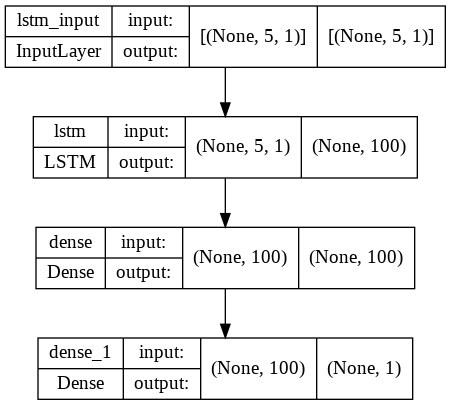

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_steps,1)))
model.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
#model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1))
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
plot_model(model, 'model.png', show_shapes=True)

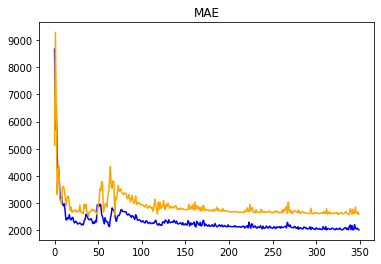

In [ ]:
hist = model.fit(X_train, y_train, epochs=350, batch_size=32, verbose=0, validation_data=(X_test, y_test))
summarize_diagnostics(hist)

In [ ]:
# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'MSE: {mse:.3f}, RMSE: {sqrt(mse):.3f}, MAE: {mae:.3f}')

# make a prediction
row = asarray([18024.0, 16722.0, 14385.0, 21342.0, 17180.0]).reshape((1, n_steps, 1))
yhat = model.predict(row)
print(f'Predicted: {yhat}') # actual 14577

MSE: 10660347.000, RMSE: 3265.019, MAE: 2590.236
Predicted: [[16328.118]]


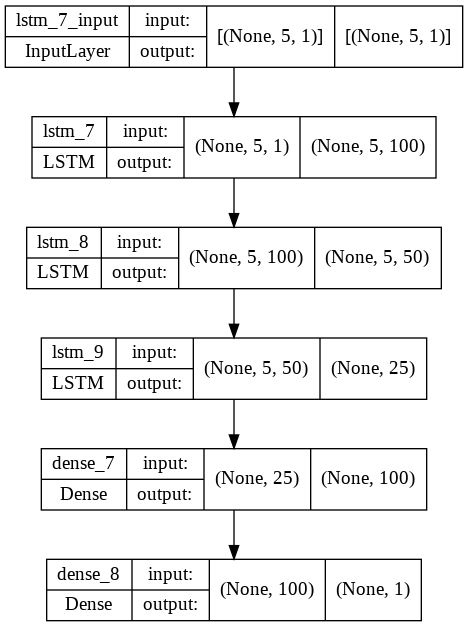

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', kernel_initializer='he_normal',
               input_shape=(n_steps,1), return_sequences = True))
#model.add(Dropout(0.3))

model.add(LSTM(50, activation='relu', kernel_initializer='he_normal',return_sequences = True))
#model.add(Dropout(0.3))

model.add(LSTM(25, activation='relu', kernel_initializer='he_normal'))
#model.add(Dropout(0.3))

model.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
#model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1))
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
plot_model(model, 'model.png', show_shapes=True)

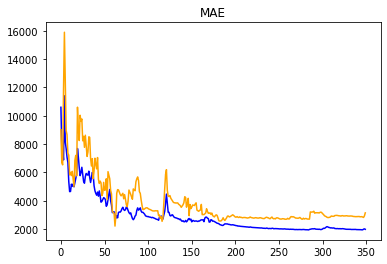

In [ ]:
hist = model.fit(X_train, y_train, epochs=350, batch_size=32, verbose=0, validation_data=(X_test, y_test))
summarize_diagnostics(hist)

In [ ]:
# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'MSE: {mse:.3f}, RMSE: {sqrt(mse):.3f}, MAE: {mae:.3f}')

# make a prediction
row = asarray([18024.0, 16722.0, 14385.0, 21342.0, 17180.0]).reshape((1, n_steps, 1))
yhat = model.predict(row)
print(f'Predicted: {yhat}') # actual 14577

MSE: 14907805.000, RMSE: 3861.063, MAE: 3146.344
Predicted: [[22492.143]]


In [ ]:
# Multi Feature One to one
nums = 25

X1 = list()
X2 = list()
X = list()
Y = list()

X1 = [(x+1)*2 for x in range(25)]
X2 = [(x+1)*3 for x in range(25)]
Y = [x1*x2 for x1,x2 in zip(X1,X2)]

print(X1)
print(X2)
print(Y)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75]
[6, 24, 54, 96, 150, 216, 294, 384, 486, 600, 726, 864, 1014, 1176, 1350, 1536, 1734, 1944, 2166, 2400, 2646, 2904, 3174, 3456, 3750]


In [ ]:
X = np.column_stack((X1, X2))
print(X)

[[ 2  3]
 [ 4  6]
 [ 6  9]
 [ 8 12]
 [10 15]
 [12 18]
 [14 21]
 [16 24]
 [18 27]
 [20 30]
 [22 33]
 [24 36]
 [26 39]
 [28 42]
 [30 45]
 [32 48]
 [34 51]
 [36 54]
 [38 57]
 [40 60]
 [42 63]
 [44 66]
 [46 69]
 [48 72]
 [50 75]]


In [ ]:
X = array(X).reshape(25, 1, 2)
Y = np.array(Y)


In [ ]:
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(1, 2)))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(25, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 1, 200)            162400    
                                                                 
 lstm_18 (LSTM)              (None, 1, 100)            120400    
                                                                 
 lstm_19 (LSTM)              (None, 1, 50)             30200     
                                                                 
 lstm_20 (LSTM)              (None, 25)                7600      
                                                                 
 dense_13 (Dense)            (None, 20)                520       
                                                                 
 dense_14 (Dense)            (None, 10)                210       
                                                                 
 dense_15 (Dense)            (None, 1)                

In [ ]:
history = model.fit(X, Y, epochs=1000, validation_split=0.1, verbose=1, batch_size=3);


In [ ]:
test_input = array([55,80])
test_input = test_input.reshape((1, 1, 2))
test_output = model.predict(test_input, verbose=0)
print(test_output) # actual 4400

[[3825.7456]]


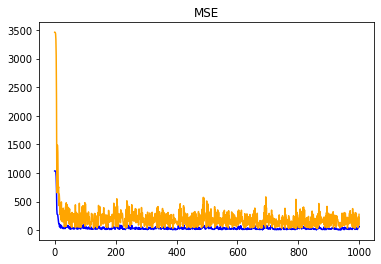

In [ ]:
summarize_diagnostics(history)

# Many To One

In [ ]:
X = np.array([x+1 for x in range(45)])
print(X)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


In [ ]:
X = X.reshape(15,3,1)
print(X)

[[[ 1]
  [ 2]
  [ 3]]

 [[ 4]
  [ 5]
  [ 6]]

 [[ 7]
  [ 8]
  [ 9]]

 [[10]
  [11]
  [12]]

 [[13]
  [14]
  [15]]

 [[16]
  [17]
  [18]]

 [[19]
  [20]
  [21]]

 [[22]
  [23]
  [24]]

 [[25]
  [26]
  [27]]

 [[28]
  [29]
  [30]]

 [[31]
  [32]
  [33]]

 [[34]
  [35]
  [36]]

 [[37]
  [38]
  [39]]

 [[40]
  [41]
  [42]]

 [[43]
  [44]
  [45]]]


In [ ]:
Y = list()
for x in X:
    Y.append(x.sum())

Y = np.array(Y)
print(Y)

[  6  15  24  33  42  51  60  69  78  87  96 105 114 123 132]


In [ ]:
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(3, 1)))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(25, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

history = model.fit(X, Y, epochs=1000, validation_split=0.2, verbose=1)

In [ ]:

test_input = array([50,51,52])
test_input = test_input.reshape((1, 3, 1))
test_output = model.predict(test_input, verbose=0)
print(test_output) # Actual 153

[[147.38995]]


In [ ]:
summarize_diagnostics(history)

# Bidirectional LSTM

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(3, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history = model.fit(X, Y, epochs=1000, validation_split=0.2, verbose=1)


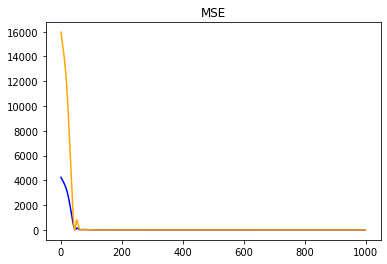

In [ ]:
summarize_diagnostics(history)

In [ ]:
test_input = array([50,51,52])
test_input = test_input.reshape((1, 3, 1))
test_output = model.predict(test_input, verbose=0)
print(test_output) # Actual 153

[[151.34166]]


In [ ]:
# Multi feature Many to one
X1 = np.array([x+3 for x in range(0, 135, 3)])
print(X1)

X2 = np.array([x+5 for x in range(0, 225, 5)])
print(X2)

[  3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54
  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 102 105 108
 111 114 117 120 123 126 129 132 135]
[  5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90
  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180
 185 190 195 200 205 210 215 220 225]


In [ ]:
X = np.column_stack((X1, X2))
X = array(X).reshape(15, 3, 2)
print(X)

[[[  3   5]
  [  6  10]
  [  9  15]]

 [[ 12  20]
  [ 15  25]
  [ 18  30]]

 [[ 21  35]
  [ 24  40]
  [ 27  45]]

 [[ 30  50]
  [ 33  55]
  [ 36  60]]

 [[ 39  65]
  [ 42  70]
  [ 45  75]]

 [[ 48  80]
  [ 51  85]
  [ 54  90]]

 [[ 57  95]
  [ 60 100]
  [ 63 105]]

 [[ 66 110]
  [ 69 115]
  [ 72 120]]

 [[ 75 125]
  [ 78 130]
  [ 81 135]]

 [[ 84 140]
  [ 87 145]
  [ 90 150]]

 [[ 93 155]
  [ 96 160]
  [ 99 165]]

 [[102 170]
  [105 175]
  [108 180]]

 [[111 185]
  [114 190]
  [117 195]]

 [[120 200]
  [123 205]
  [126 210]]

 [[129 215]
  [132 220]
  [135 225]]]


In [ ]:
Y = [ 24,  48,  72,  96, 120, 144, 168, 192, 216, 240, 264, 288, 312, 336, 360]
Y = np.array(Y)
print(Y)

[ 24  48  72  96 120 144 168 192 216 240 264 288 312 336 360]


In [ ]:
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(3, 2)))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(25, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, Y, epochs=1000, validation_split=0.2, verbose=1)


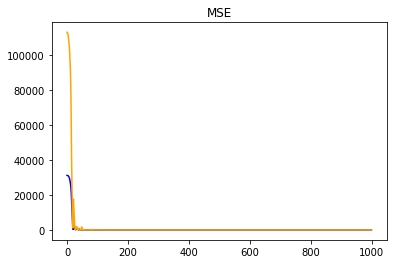

In [ ]:
summarize_diagnostics(history)

In [ ]:
test_input = array([[8, 51],
                    [11,56],
                    [14,61]])

test_input = test_input.reshape((1, 3, 2))
test_output = model.predict(test_input, verbose=0)
print(test_output) # Actual 75

[[72.668686]]


1/1 [==============================] - 0s 40ms/step - loss: 0.0014 - val_loss: 0.1548
Epoch 871/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.0014 - val_loss: 0.1536
Epoch 872/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.0014 - val_loss: 0.1546
Epoch 873/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.0014 - val_loss: 0.1571
Epoch 874/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.0015 - val_loss: 0.1524
Epoch 875/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.0014 - val_loss: 0.1470
Epoch 876/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0014 - val_loss: 0.1487
Epoch 877/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.0014 - val_loss: 0.1517
Epoch 878/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0014 - val_loss: 0.1489
Epoch 879/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.0014 - val_loss: 0.1455
Epoch

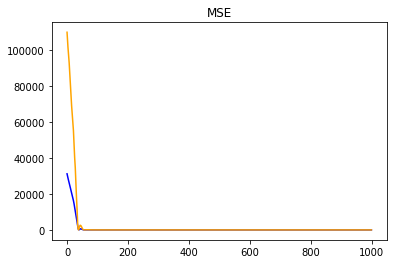

In [ ]:
# Bidirectional LSTM
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(3, 2)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, Y, epochs=1000, validation_split=0.2, verbose=1)
summarize_diagnostics(history)

In [ ]:
test_output = model.predict(test_input, verbose=0)
print(test_output) # Actual 75

[[71.89485]]


In [ ]:
# Target List Type Problem
X1 = np.array([x+3 for x in range(0, 135, 3)])


X2 = np.array([x+5 for x in range(0, 225, 5)])


X = np.column_stack((X1, X2))
X = array(X).reshape(15, 3, 2)
print(X)



[[[  3   5]
  [  6  10]
  [  9  15]]

 [[ 12  20]
  [ 15  25]
  [ 18  30]]

 [[ 21  35]
  [ 24  40]
  [ 27  45]]

 [[ 30  50]
  [ 33  55]
  [ 36  60]]

 [[ 39  65]
  [ 42  70]
  [ 45  75]]

 [[ 48  80]
  [ 51  85]
  [ 54  90]]

 [[ 57  95]
  [ 60 100]
  [ 63 105]]

 [[ 66 110]
  [ 69 115]
  [ 72 120]]

 [[ 75 125]
  [ 78 130]
  [ 81 135]]

 [[ 84 140]
  [ 87 145]
  [ 90 150]]

 [[ 93 155]
  [ 96 160]
  [ 99 165]]

 [[102 170]
  [105 175]
  [108 180]]

 [[111 185]
  [114 190]
  [117 195]]

 [[120 200]
  [123 205]
  [126 210]]

 [[129 215]
  [132 220]
  [135 225]]]


In [ ]:
Y = list()
for x in X:
    new_item = list()
    new_item.append(x[2][0]+3)
    new_item.append(x[2][1]+5)
    Y.append(new_item)

Y = np.array(Y)
print(Y)

[[ 12  20]
 [ 21  35]
 [ 30  50]
 [ 39  65]
 [ 48  80]
 [ 57  95]
 [ 66 110]
 [ 75 125]
 [ 84 140]
 [ 93 155]
 [102 170]
 [111 185]
 [120 200]
 [129 215]
 [138 230]]


In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(3, 2)))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(25, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, Y, epochs=500, validation_split=0.2, verbose=1)

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 8967.7109 - val_loss: 31441.4746
Epoch 2/500
1/1 [==============================] - 0s 40ms/step - loss: 8946.3369 - val_loss: 31353.9434
Epoch 3/500
1/1 [==============================] - 0s 39ms/step - loss: 8931.0381 - val_loss: 31278.4004
Epoch 4/500
1/1 [==============================] - 0s 35ms/step - loss: 8912.5381 - val_loss: 31180.0723
Epoch 5/500
1/1 [==============================] - 0s 38ms/step - loss: 8889.1777 - val_loss: 31038.8770
Epoch 6/500
1/1 [==============================] - 0s 38ms/step - loss: 8860.9893 - val_loss: 30904.3691
Epoch 7/500
1/1 [==============================] - 0s 33ms/step - loss: 8828.6865 - val_loss: 30763.6309
Epoch 8/500
1/1 [==============================] - 0s 36ms/step - loss: 8791.9268 - val_loss: 30604.8535
Epoch 9/500
1/1 [==============================] - 0s 38ms/step - loss: 8749.8828 - val_loss: 30442.2520
Epoch 10/500
1/1 [==============================] - 0s 38

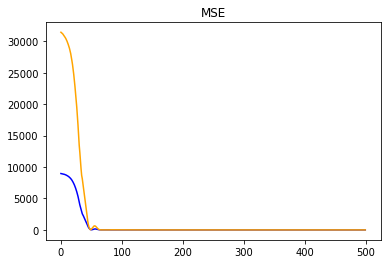

In [ ]:
summarize_diagnostics(history)

In [ ]:
test_input = array([[20,34],
                    [23,39],
                    [26,44]])

test_input = test_input.reshape((1, 3, 2))
test_output = model.predict(test_input, verbose=0)
print(test_output) # Actual [29, 45]

[[29.196838 48.61732 ]]


In [ ]:
# Bidirectional LSTM
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(3, 2)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, Y, epochs=1000, validation_split=0.2, verbose=1)

1/1 [==============================] - 0s 38ms/step - loss: 2.6815e-04 - val_loss: 0.2153
Epoch 913/1000
1/1 [==============================] - 0s 41ms/step - loss: 2.6858e-04 - val_loss: 0.2188
Epoch 914/1000
1/1 [==============================] - 0s 38ms/step - loss: 2.6630e-04 - val_loss: 0.2144
Epoch 915/1000
1/1 [==============================] - 0s 33ms/step - loss: 2.6247e-04 - val_loss: 0.2162
Epoch 916/1000
1/1 [==============================] - 0s 35ms/step - loss: 2.5868e-04 - val_loss: 0.2144
Epoch 917/1000
1/1 [==============================] - 0s 33ms/step - loss: 2.5625e-04 - val_loss: 0.2134
Epoch 918/1000
1/1 [==============================] - 0s 42ms/step - loss: 2.5570e-04 - val_loss: 0.2143
Epoch 919/1000
1/1 [==============================] - 0s 34ms/step - loss: 2.5609e-04 - val_loss: 0.2112
Epoch 920/1000
1/1 [==============================] - 0s 35ms/step - loss: 2.5671e-04 - val_loss: 0.2134
Epoch 921/1000
1/1 [==============================] - 0s 38ms/step - l

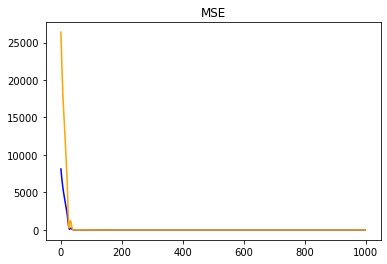

In [ ]:
summarize_diagnostics(history)

In [ ]:
test_output = model.predict(test_input, verbose=0)
print(test_output) # Actual [29, 45]

[[29.234304 48.707222]]


# One to Many

In [ ]:
X = list()
Y = list()
X = [x+3 for x in range(-2, 43, 3)]

for i in X:
    output_vector = list()
    output_vector.append(i+1)
    output_vector.append(i+2)
    Y.append(output_vector)

print(X)
print(Y)

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43]
[[2, 3], [5, 6], [8, 9], [11, 12], [14, 15], [17, 18], [20, 21], [23, 24], [26, 27], [29, 30], [32, 33], [35, 36], [38, 39], [41, 42], [44, 45]]


In [ ]:
X = np.array(X).reshape(15, 1, 1)
Y = np.array(Y)

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')
history = model.fit(X, Y, epochs=1000, validation_split=0.2, verbose=1, batch_size=3)


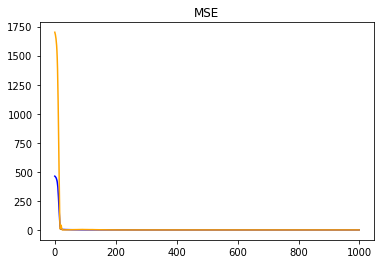

In [ ]:
summarize_diagnostics(history)

In [ ]:
test_input = array([10])
test_input = test_input.reshape((1, 1, 1))
test_output = model.predict(test_input, verbose=0)
print(test_output) # Actual [11,12]

[[11.030559 11.976977]]


In [ ]:
# Bidirectional LSTM
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(1, 1)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, Y, epochs=1000, validation_split=0.2, verbose=1, batch_size=3)

4/4 [==============================] - 0s 10ms/step - loss: 0.0057 - val_loss: 0.0942
Epoch 601/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.0057 - val_loss: 0.0954
Epoch 602/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.0057 - val_loss: 0.0968
Epoch 603/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.0057 - val_loss: 0.0994
Epoch 604/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.0057 - val_loss: 0.0943
Epoch 605/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.0056 - val_loss: 0.0981
Epoch 606/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.0056 - val_loss: 0.1007
Epoch 607/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.0056 - val_loss: 0.0958
Epoch 608/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.0056 - val_loss: 0.0987
Epoch 609/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.0055 - val_loss: 0.0953
Epoch 610

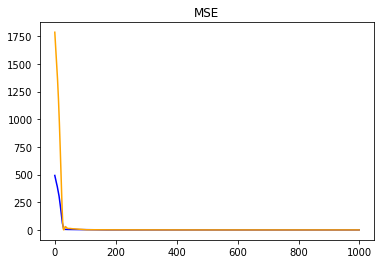

In [ ]:
summarize_diagnostics(history)

In [ ]:
test_output = model.predict(test_input, verbose=0)
print(test_output) # Actual [11,12]

[[10.986604 11.986187]]


In [ ]:
# Multiple Features
nums = 25

X1 = list()
X2 = list()
X = list()
Y = list()

X1 = [(x+1)*2 for x in range(25)]
X2 = [(x+1)*3 for x in range(25)]

for x1, x2 in zip(X1, X2):
    output_vector = list()
    output_vector.append(x1+1)
    output_vector.append(x2+1)
    Y.append(output_vector)

X = np.column_stack((X1, X2))
print(X)

[[ 2  3]
 [ 4  6]
 [ 6  9]
 [ 8 12]
 [10 15]
 [12 18]
 [14 21]
 [16 24]
 [18 27]
 [20 30]
 [22 33]
 [24 36]
 [26 39]
 [28 42]
 [30 45]
 [32 48]
 [34 51]
 [36 54]
 [38 57]
 [40 60]
 [42 63]
 [44 66]
 [46 69]
 [48 72]
 [50 75]]


In [ ]:
X = np.array(X).reshape(25, 1, 2)
Y = np.array(Y)

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, 2)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')
history = model.fit(X, Y, epochs=1000, validation_split=0.2, verbose=1, batch_size=3)

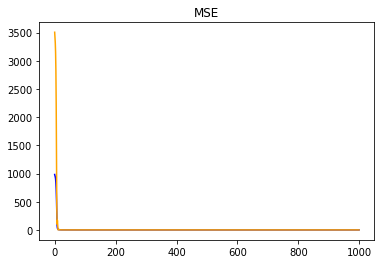

In [ ]:
summarize_diagnostics(history)

In [ ]:
test_input = array([40, 60])
test_input = test_input.reshape((1, 1, 2))
test_output = model.predict(test_input, verbose=0)
print(test_output) # Actual [41,61]

[[40.960285 60.95718 ]]


In [ ]:
# Bidirectional LSTM
from keras.layers import Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(1, 2)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, Y, epochs=1000, validation_split=0.2, verbose=1, batch_size=3)

Epoch 1/1000
7/7 [==============================] - 2s 59ms/step - loss: 983.4398 - val_loss: 3396.9199
Epoch 2/1000
7/7 [==============================] - 0s 11ms/step - loss: 913.0199 - val_loss: 3113.7473
Epoch 3/1000
7/7 [==============================] - 0s 9ms/step - loss: 837.2972 - val_loss: 2847.1279
Epoch 4/1000
7/7 [==============================] - 0s 9ms/step - loss: 760.6270 - val_loss: 2549.0977
Epoch 5/1000
7/7 [==============================] - 0s 10ms/step - loss: 673.7613 - val_loss: 2207.4531
Epoch 6/1000
7/7 [==============================] - 0s 9ms/step - loss: 567.6879 - val_loss: 1808.0742
Epoch 7/1000
7/7 [==============================] - 0s 9ms/step - loss: 456.8609 - val_loss: 1334.2549
Epoch 8/1000
7/7 [==============================] - 0s 9ms/step - loss: 326.6717 - val_loss: 837.8795
Epoch 9/1000
7/7 [==============================] - 0s 10ms/step - loss: 197.9238 - val_loss: 333.8928
Epoch 10/1000
7/7 [==============================] - 0s 9ms/step - loss

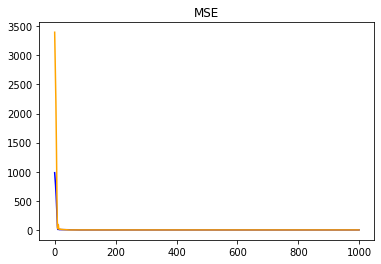

In [ ]:
summarize_diagnostics(history)

In [ ]:
test_output = model.predict(test_input, verbose=0)
print(test_output) # Actual [41,61]

[[40.978573 60.977768]]


# Many To Many

In [ ]:
X = list()
Y = list()
X = [x for x in range(5, 301, 5)]
Y = [y for y in range(20, 316, 5)]

X = np.array(X).reshape(20, 3, 1)
Y = np.array(Y).reshape(20, 3, 1)

In [ ]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

model = Sequential()

# encoder layer
model.add(LSTM(100, activation='relu', input_shape=(3, 1)))

# repeat vector
model.add(RepeatVector(3))

# decoder layer
model.add(LSTM(100, activation='relu', return_sequences=True))

model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

print(model.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 100)               40800     
                                                                 
 repeat_vector (RepeatVector  (None, 3, 100)           0         
 )                                                               
                                                                 
 lstm_44 (LSTM)              (None, 3, 100)            80400     
                                                                 
 time_distributed (TimeDistr  (None, 3, 1)             101       
 ibuted)                                                         
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X, Y, epochs=1000, validation_split=0.2, verbose=1, batch_size=3)

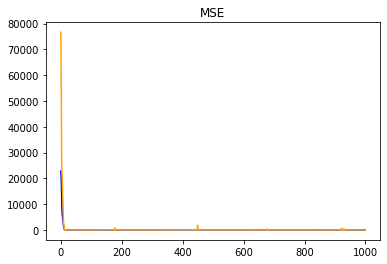

In [ ]:
summarize_diagnostics(history)

In [ ]:
test_input = array([300, 305, 310])
test_input = test_input.reshape((1, 3, 1))
test_output = model.predict(test_input, verbose=0)
print(test_output) # Actual [315,320,325]

[[[315.31244]
  [321.2981 ]
  [327.5832 ]]]
